In [1]:
import random
import numpy as np
import random
import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras import models
from keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# number of characters in a word.
# for instance abccba has nb_chars = 6
nb_chars = 4

# number of possible characters used during the encoding.
# for instance abcde leads to 01234 has nb_letters = 5
nb_letters = 26

# number of words samples to be generated 
nb_words = 40000

# percentage of words that will be used for validation
percentage_split = 0.9

# number of epochs for fitting the model training step
nb_epochs = 200

In [3]:
# total number of combinations
nb_letters**nb_chars

456976

In [4]:
def create_inputs(nb_words, nb_chars, nb_letters):
    '''Create a numpy array of nb_words rows with nb_chars columns each element
    being a random letter of nb_letters (a, b...)'''
    words = np.zeros((nb_words, nb_chars, 1), dtype=int)
    
    for w in range(nb_words):
        optim_tentative = False
        if optim_tentative == True and w%10 != 0:
            i = random.randint(0, nb_letters-1)
            for c in range(nb_chars):
                words[w, c, 0] = ord('a') + i
        else:
            for c in range(nb_chars):
                i = random.randint(0, nb_letters-1)
                words[w, c, 0] = ord('a') + i
                
    return words


def encrypt(words, nb_words, nb_chars):
    '''Encrypt each element of a numpy array of nb_words rows with nb_chars 
    columns each item with a secret algorithm'''
    
    encrypted_words = words.copy()
    encrypted_words_probs = np.zeros((nb_words, nb_chars, nb_chars))
    
    #val_max = -1
    
    for w in range(nb_words):
        for c in range(nb_chars): # 0,1,2,3,4
            
            encrypted_words[w,c] = int(words[w,c]) - 49
            val = encrypted_words[w,c] - 48
            
            #if val > val_max:
            #    val_max = val
            
            # add entropy (i.e. mistakes in the encryption)
            #epsilon = random.randint(0, 100)
            #if epsilon == 5 and val != val_max:
            #val +=1
            
            #print('w:',w,', c:',c,', [wc]:', val)
            #encrypted_words_probs[w, c, val ] = 1.0
            encrypted_words[w,c] = val
    return encrypted_words

In [5]:
def normalize(x):
    # normalize x_test data
    mean = x.mean(axis=0)
    x_normalized = x - mean
    std = x_normalized.std(axis=0)
    x_normalized /= std
    return x_normalized

In [6]:
def build_model(nb_chars, nb_letters):

    # This returns a tensor
    inputs = layers.Input(shape=(nb_chars,1,), dtype='float32', name='main_input')

    # a layer instance is callable on a tensor, and returns a tensor
    x = layers.Dense(1024, activation='relu', name='hl_1')(inputs)
    #x = layers.Dropout(0.4)(x)
    x = layers.Conv1D(256, 3, activation='relu', padding='same', name='conv_1d')(x)
    x = layers.MaxPooling1D(3)(x)
    #x = layers.AveragePooling1D(3)(x)
    x = layers.Dense(64, activation='relu', name='hl_2')(x)

    outputs = []
    losses = {}
    for o in range(nb_chars):
        name_i = 'output_'+str(o)
        output_i = layers.Dense(nb_letters, activation='softmax', dtype='float32', name=name_i)(x)
        outputs.append(output_i)
        losses[name_i] = 'categorical_crossentropy'

    model = keras.models.Model(inputs=inputs, outputs=outputs)

    rmsprop = keras.optimizers.RMSprop(lr=0.001)

    model.compile(optimizer=rmsprop,
                         loss=losses,
                         metrics=['accuracy'])       
    return model

In [7]:
def print_readable_inputs(x):
    words = []
    for w in x:
        word = []
        for c in w:
            word.append(c)
        words.append(word)
   
    print(words)

In [8]:
def print_readable_outputs_(outputs, nb_words, nb_chars):
    
    # outputs are listed : first, per char, second by sample, third by letter probability
    words = [''] * nb_words
    
    c_i = 0
    for char in outputs:

        s_i = 0
        for sample in char:

            l_i = 0
            best_value = -float('inf')
            best_letter = -1
            for letter_probs in sample:
                if letter_probs > best_value:
                    best_value = letter_probs
                    best_letter = l_i
                l_i += 1
            words[s_i] += str(best_letter)
            if c_i != nb_chars - 1:
                words[s_i] += ' '
            s_i += 1
        c_i += 1
    print(words)

In [9]:
def print_readable_outputs(outputs, nb_words, nb_chars):
    
    # outputs are listed : first, per char, second by sample, third by letter probability
    words = [''] * nb_words
    c_i = 0
    for char in outputs:
        s_i = 0
        for sample in char:
            best_letter = np.argmax(sample)
            words[s_i] += str(best_letter)
            if c_i != nb_chars - 1:
                words[s_i] += ' '
            s_i += 1
        c_i += 1
    print(words)

In [10]:
x = create_inputs(nb_words, nb_chars, nb_letters)
print('x: (as readable inputs)')

first_n_samples = 2

#print_readable_inputs(x[:first_n_samples])
print('x (partial):\n', x[:first_n_samples], 'out of ',len(x))
print()


# Normalize the data
x_train = normalize(x)

print('x_train:\n', x_train[:first_n_samples], 'out of ',len(x_train))
print()

# create output data for training
y = encrypt(x, nb_words, nb_chars)
print('y (readable):\n', y)
print()

# process the y data as useful ANN output data
y_train0 = keras.utils.to_categorical(y, nb_letters)
print('y (less readable):\n', y_train0[:first_n_samples], 'out of ',len(y_train0))
print('')


print('y.shape',y.shape)

y_train = []
for c in range(nb_chars):
    # extract each 'char' colomn from the global y_train0 tensor
    # in order to have multiplue yi_train outputs tensors    
    yi_train = np.ndarray(shape=(nb_words, 1, nb_letters))
    for w in range(nb_words):
        yi_train[w,:] = y_train0[w,c,:]
    y_train.append(yi_train)

# Not really displayable, henced commented
print('y_train):')
print(y_train[:first_n_samples])

print('y_train[0].shape=',y_train[0].shape)

x: (as readable inputs)
x (partial):
 [[[108]
  [100]
  [117]
  [101]]

 [[114]
  [105]
  [116]
  [ 98]]] out of  40000

x_train:
 [[[-0.19803652]
  [-1.2741154 ]
  [ 0.99438854]
  [-1.13152572]]

 [[ 0.60293358]
  [-0.60525155]
  [ 0.86124776]
  [-1.53095823]]] out of  40000

y (readable):
 [[[11]
  [ 3]
  [20]
  [ 4]]

 [[17]
  [ 8]
  [19]
  [ 1]]

 [[10]
  [ 8]
  [23]
  [20]]

 ...

 [[13]
  [ 4]
  [ 9]
  [ 0]]

 [[17]
  [ 0]
  [24]
  [19]]

 [[19]
  [14]
  [25]
  [ 5]]]

y (less readable):
 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 

In [11]:
coding_model = build_model(nb_chars, nb_letters)
print(coding_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 4, 1)         0                                            
__________________________________________________________________________________________________
hl_1 (Dense)                    (None, 4, 1024)      2048        main_input[0][0]                 
__________________________________________________________________________________________________
conv_1d (Conv1D)                (None, 4, 256)       786688      hl_1[0][0]                       
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 1, 256)       0           conv_1d[0][0]                    
__________________________________________________________________________________________________
hl_2 (Dens

In [12]:
history = coding_model.fit(x_train, y_train, validation_split=percentage_split, batch_size=32, epochs=nb_epochs, verbose=1)

Train on 3999 samples, validate on 36001 samples
Epoch 1/200
3999/3999 [==============================] - 5s 1ms/step - loss: 12.4148 - output_0_loss: 3.0764 - output_1_loss: 3.0669 - output_2_loss: 3.1250 - output_3_loss: 3.1466 - output_0_acc: 0.0863 - output_1_acc: 0.0853 - output_2_acc: 0.0733 - output_3_acc: 0.0718 - val_loss: 11.8018 - val_output_0_loss: 2.8391 - val_output_1_loss: 2.8489 - val_output_2_loss: 3.0544 - val_output_3_loss: 3.0593 - val_output_0_acc: 0.1034 - val_output_1_acc: 0.1064 - val_output_2_acc: 0.0829 - val_output_3_acc: 0.0876
Epoch 2/200
3999/3999 [==============================] - 4s 1ms/step - loss: 11.0227 - output_0_loss: 2.6465 - output_1_loss: 2.6416 - output_2_loss: 2.8240 - output_3_loss: 2.9107 - output_0_acc: 0.1368 - output_1_acc: 0.1460 - output_2_acc: 0.1178 - output_3_acc: 0.1055 - val_loss: 10.3224 - val_output_0_loss: 2.4270 - val_output_1_loss: 2.3827 - val_output_2_loss: 2.6989 - val_output_3_loss: 2.8138 - val_output_0_acc: 0.1602 - val_

Epoch 17/200
3999/3999 [==============================] - 4s 1ms/step - loss: 5.1109 - output_0_loss: 1.1050 - output_1_loss: 1.0418 - output_2_loss: 1.3357 - output_3_loss: 1.6283 - output_0_acc: 0.5396 - output_1_acc: 0.5649 - output_2_acc: 0.4506 - output_3_acc: 0.3751 - val_loss: 5.7096 - val_output_0_loss: 1.2544 - val_output_1_loss: 1.0783 - val_output_2_loss: 1.4472 - val_output_3_loss: 1.9296 - val_output_0_acc: 0.4718 - val_output_1_acc: 0.5346 - val_output_2_acc: 0.4277 - val_output_3_acc: 0.3062
Epoch 18/200
3999/3999 [==============================] - 4s 1ms/step - loss: 4.9748 - output_0_loss: 1.0631 - output_1_loss: 1.0151 - output_2_loss: 1.3114 - output_3_loss: 1.5852 - output_0_acc: 0.5499 - output_1_acc: 0.5761 - output_2_acc: 0.4636 - output_3_acc: 0.3858 - val_loss: 5.1643 - val_output_0_loss: 1.0275 - val_output_1_loss: 1.0541 - val_output_2_loss: 1.3543 - val_output_3_loss: 1.7283 - val_output_0_acc: 0.5752 - val_output_1_acc: 0.5529 - val_output_2_acc: 0.4323 - v

3999/3999 [==============================] - 5s 1ms/step - loss: 3.2092 - output_0_loss: 0.6419 - output_1_loss: 0.5669 - output_2_loss: 0.8762 - output_3_loss: 1.1241 - output_0_acc: 0.7289 - output_1_acc: 0.7737 - output_2_acc: 0.6419 - output_3_acc: 0.5464 - val_loss: 3.6649 - val_output_0_loss: 0.6735 - val_output_1_loss: 0.6310 - val_output_2_loss: 1.0601 - val_output_3_loss: 1.3003 - val_output_0_acc: 0.7052 - val_output_1_acc: 0.7257 - val_output_2_acc: 0.5586 - val_output_3_acc: 0.4756
Epoch 34/200
3999/3999 [==============================] - 4s 1ms/step - loss: 3.1295 - output_0_loss: 0.5944 - output_1_loss: 0.5762 - output_2_loss: 0.8502 - output_3_loss: 1.1087 - output_0_acc: 0.7572 - output_1_acc: 0.7752 - output_2_acc: 0.6427 - output_3_acc: 0.5516 - val_loss: 3.6848 - val_output_0_loss: 0.5966 - val_output_1_loss: 0.7276 - val_output_2_loss: 1.0442 - val_output_3_loss: 1.3164 - val_output_0_acc: 0.7587 - val_output_1_acc: 0.6860 - val_output_2_acc: 0.5758 - val_output_3_a

3999/3999 [==============================] - 4s 1ms/step - loss: 2.1477 - output_0_loss: 0.3489 - output_1_loss: 0.3314 - output_2_loss: 0.6097 - output_3_loss: 0.8576 - output_0_acc: 0.8640 - output_1_acc: 0.8725 - output_2_acc: 0.7527 - output_3_acc: 0.6597 - val_loss: 2.3704 - val_output_0_loss: 0.4483 - val_output_1_loss: 0.3854 - val_output_2_loss: 0.6135 - val_output_3_loss: 0.9231 - val_output_0_acc: 0.8331 - val_output_1_acc: 0.8524 - val_output_2_acc: 0.7555 - val_output_3_acc: 0.6278
Epoch 50/200
3999/3999 [==============================] - 4s 1ms/step - loss: 2.0949 - output_0_loss: 0.3386 - output_1_loss: 0.3293 - output_2_loss: 0.6249 - output_3_loss: 0.8021 - output_0_acc: 0.8717 - output_1_acc: 0.8777 - output_2_acc: 0.7584 - output_3_acc: 0.6724 - val_loss: 3.0459 - val_output_0_loss: 0.4158 - val_output_1_loss: 0.4521 - val_output_2_loss: 1.0004 - val_output_3_loss: 1.1777 - val_output_0_acc: 0.8328 - val_output_1_acc: 0.8124 - val_output_2_acc: 0.6304 - val_output_3_a

3999/3999 [==============================] - 4s 1ms/step - loss: 1.5289 - output_0_loss: 0.2143 - output_1_loss: 0.2235 - output_2_loss: 0.4340 - output_3_loss: 0.6571 - output_0_acc: 0.9250 - output_1_acc: 0.9207 - output_2_acc: 0.8262 - output_3_acc: 0.7514 - val_loss: 1.9736 - val_output_0_loss: 0.2698 - val_output_1_loss: 0.2606 - val_output_2_loss: 0.5200 - val_output_3_loss: 0.9232 - val_output_0_acc: 0.8934 - val_output_1_acc: 0.9039 - val_output_2_acc: 0.7980 - val_output_3_acc: 0.6658
Epoch 66/200
3999/3999 [==============================] - 4s 1ms/step - loss: 1.5357 - output_0_loss: 0.2146 - output_1_loss: 0.2228 - output_2_loss: 0.4692 - output_3_loss: 0.6291 - output_0_acc: 0.9205 - output_1_acc: 0.9147 - output_2_acc: 0.8260 - output_3_acc: 0.7622 - val_loss: 1.7616 - val_output_0_loss: 0.2352 - val_output_1_loss: 0.2809 - val_output_2_loss: 0.5281 - val_output_3_loss: 0.7174 - val_output_0_acc: 0.9173 - val_output_1_acc: 0.8964 - val_output_2_acc: 0.8052 - val_output_3_a

3999/3999 [==============================] - 5s 1ms/step - loss: 1.2118 - output_0_loss: 0.1620 - output_1_loss: 0.1564 - output_2_loss: 0.3636 - output_3_loss: 0.5298 - output_0_acc: 0.9465 - output_1_acc: 0.9455 - output_2_acc: 0.8712 - output_3_acc: 0.8110 - val_loss: 2.3958 - val_output_0_loss: 0.2530 - val_output_1_loss: 0.4098 - val_output_2_loss: 0.4796 - val_output_3_loss: 1.2533 - val_output_0_acc: 0.9129 - val_output_1_acc: 0.8569 - val_output_2_acc: 0.8284 - val_output_3_acc: 0.6621
Epoch 82/200
3999/3999 [==============================] - 5s 1ms/step - loss: 1.1934 - output_0_loss: 0.1414 - output_1_loss: 0.1392 - output_2_loss: 0.3898 - output_3_loss: 0.5230 - output_0_acc: 0.9545 - output_1_acc: 0.9515 - output_2_acc: 0.8547 - output_3_acc: 0.8065 - val_loss: 1.2972 - val_output_0_loss: 0.1450 - val_output_1_loss: 0.1720 - val_output_2_loss: 0.3537 - val_output_3_loss: 0.6266 - val_output_0_acc: 0.9509 - val_output_1_acc: 0.9394 - val_output_2_acc: 0.8649 - val_output_3_a

3999/3999 [==============================] - 5s 1ms/step - loss: 1.0167 - output_0_loss: 0.1315 - output_1_loss: 0.1114 - output_2_loss: 0.3342 - output_3_loss: 0.4396 - output_0_acc: 0.9532 - output_1_acc: 0.9627 - output_2_acc: 0.8857 - output_3_acc: 0.8382 - val_loss: 1.7092 - val_output_0_loss: 0.1520 - val_output_1_loss: 0.3228 - val_output_2_loss: 0.3193 - val_output_3_loss: 0.9152 - val_output_0_acc: 0.9428 - val_output_1_acc: 0.8955 - val_output_2_acc: 0.8827 - val_output_3_acc: 0.7122
Epoch 98/200
3999/3999 [==============================] - 5s 1ms/step - loss: 1.0080 - output_0_loss: 0.1272 - output_1_loss: 0.1242 - output_2_loss: 0.2737 - output_3_loss: 0.4829 - output_0_acc: 0.9560 - output_1_acc: 0.9535 - output_2_acc: 0.9060 - output_3_acc: 0.8320 - val_loss: 1.4208 - val_output_0_loss: 0.1476 - val_output_1_loss: 0.1619 - val_output_2_loss: 0.5381 - val_output_3_loss: 0.5732 - val_output_0_acc: 0.9513 - val_output_1_acc: 0.9448 - val_output_2_acc: 0.8324 - val_output_3_a

3999/3999 [==============================] - 5s 1ms/step - loss: 0.8900 - output_0_loss: 0.1077 - output_1_loss: 0.1121 - output_2_loss: 0.2627 - output_3_loss: 0.4074 - output_0_acc: 0.9670 - output_1_acc: 0.9627 - output_2_acc: 0.9122 - output_3_acc: 0.8645 - val_loss: 1.5537 - val_output_0_loss: 0.3122 - val_output_1_loss: 0.1446 - val_output_2_loss: 0.4954 - val_output_3_loss: 0.6015 - val_output_0_acc: 0.9142 - val_output_1_acc: 0.9508 - val_output_2_acc: 0.8310 - val_output_3_acc: 0.7951
Epoch 114/200
3999/3999 [==============================] - 5s 1ms/step - loss: 0.8671 - output_0_loss: 0.1058 - output_1_loss: 0.1174 - output_2_loss: 0.2623 - output_3_loss: 0.3816 - output_0_acc: 0.9637 - output_1_acc: 0.9632 - output_2_acc: 0.9090 - output_3_acc: 0.8742 - val_loss: 1.4322 - val_output_0_loss: 0.1568 - val_output_1_loss: 0.1346 - val_output_2_loss: 0.3358 - val_output_3_loss: 0.8050 - val_output_0_acc: 0.9441 - val_output_1_acc: 0.9556 - val_output_2_acc: 0.8923 - val_output_3_

Epoch 129/200
3999/3999 [==============================] - 4s 1ms/step - loss: 0.7699 - output_0_loss: 0.0896 - output_1_loss: 0.0846 - output_2_loss: 0.2546 - output_3_loss: 0.3411 - output_0_acc: 0.9707 - output_1_acc: 0.9757 - output_2_acc: 0.9190 - output_3_acc: 0.8880 - val_loss: 1.2340 - val_output_0_loss: 0.1355 - val_output_1_loss: 0.1595 - val_output_2_loss: 0.2708 - val_output_3_loss: 0.6683 - val_output_0_acc: 0.9531 - val_output_1_acc: 0.9479 - val_output_2_acc: 0.9189 - val_output_3_acc: 0.8067
Epoch 130/200
3999/3999 [==============================] - 5s 1ms/step - loss: 0.7929 - output_0_loss: 0.1035 - output_1_loss: 0.0871 - output_2_loss: 0.2394 - output_3_loss: 0.3630 - output_0_acc: 0.9672 - output_1_acc: 0.9685 - output_2_acc: 0.9220 - output_3_acc: 0.8787 - val_loss: 1.0990 - val_output_0_loss: 0.0667 - val_output_1_loss: 0.1516 - val_output_2_loss: 0.3324 - val_output_3_loss: 0.5483 - val_output_0_acc: 0.9780 - val_output_1_acc: 0.9540 - val_output_2_acc: 0.8984 -

Epoch 145/200
3999/3999 [==============================] - 5s 1ms/step - loss: 0.7749 - output_0_loss: 0.1130 - output_1_loss: 0.0729 - output_2_loss: 0.2384 - output_3_loss: 0.3506 - output_0_acc: 0.9637 - output_1_acc: 0.9742 - output_2_acc: 0.9240 - output_3_acc: 0.8942 - val_loss: 1.1880 - val_output_0_loss: 0.1499 - val_output_1_loss: 0.1703 - val_output_2_loss: 0.3321 - val_output_3_loss: 0.5357 - val_output_0_acc: 0.9494 - val_output_1_acc: 0.9514 - val_output_2_acc: 0.8993 - val_output_3_acc: 0.8460
Epoch 146/200
3999/3999 [==============================] - 5s 1ms/step - loss: 0.7217 - output_0_loss: 0.1010 - output_1_loss: 0.0797 - output_2_loss: 0.1988 - output_3_loss: 0.3422 - output_0_acc: 0.9715 - output_1_acc: 0.9740 - output_2_acc: 0.9415 - output_3_acc: 0.8915 - val_loss: 1.1092 - val_output_0_loss: 0.1255 - val_output_1_loss: 0.1295 - val_output_2_loss: 0.3049 - val_output_3_loss: 0.5494 - val_output_0_acc: 0.9606 - val_output_1_acc: 0.9594 - val_output_2_acc: 0.9171 -

Epoch 161/200
3999/3999 [==============================] - 5s 1ms/step - loss: 0.6848 - output_0_loss: 0.0779 - output_1_loss: 0.0849 - output_2_loss: 0.2105 - output_3_loss: 0.3114 - output_0_acc: 0.9770 - output_1_acc: 0.9722 - output_2_acc: 0.9315 - output_3_acc: 0.9015 - val_loss: 1.5658 - val_output_0_loss: 0.1712 - val_output_1_loss: 0.2685 - val_output_2_loss: 0.5414 - val_output_3_loss: 0.5847 - val_output_0_acc: 0.9475 - val_output_1_acc: 0.9231 - val_output_2_acc: 0.8742 - val_output_3_acc: 0.8493
Epoch 162/200
3999/3999 [==============================] - 4s 1ms/step - loss: 0.7004 - output_0_loss: 0.0999 - output_1_loss: 0.0758 - output_2_loss: 0.2048 - output_3_loss: 0.3199 - output_0_acc: 0.9697 - output_1_acc: 0.9770 - output_2_acc: 0.9405 - output_3_acc: 0.9090 - val_loss: 2.3400 - val_output_0_loss: 0.1089 - val_output_1_loss: 0.3946 - val_output_2_loss: 1.0296 - val_output_3_loss: 0.8069 - val_output_0_acc: 0.9687 - val_output_1_acc: 0.8854 - val_output_2_acc: 0.8080 -

Epoch 177/200
3999/3999 [==============================] - 4s 1ms/step - loss: 0.6696 - output_0_loss: 0.0805 - output_1_loss: 0.0845 - output_2_loss: 0.2123 - output_3_loss: 0.2925 - output_0_acc: 0.9777 - output_1_acc: 0.9732 - output_2_acc: 0.9420 - output_3_acc: 0.9125 - val_loss: 1.1026 - val_output_0_loss: 0.0748 - val_output_1_loss: 0.1118 - val_output_2_loss: 0.3193 - val_output_3_loss: 0.5967 - val_output_0_acc: 0.9804 - val_output_1_acc: 0.9712 - val_output_2_acc: 0.9197 - val_output_3_acc: 0.8494
Epoch 178/200
3999/3999 [==============================] - 4s 1ms/step - loss: 0.6658 - output_0_loss: 0.0678 - output_1_loss: 0.0841 - output_2_loss: 0.2307 - output_3_loss: 0.2833 - output_0_acc: 0.9742 - output_1_acc: 0.9770 - output_2_acc: 0.9355 - output_3_acc: 0.9192 - val_loss: 1.0448 - val_output_0_loss: 0.0964 - val_output_1_loss: 0.2132 - val_output_2_loss: 0.3197 - val_output_3_loss: 0.4155 - val_output_0_acc: 0.9707 - val_output_1_acc: 0.9486 - val_output_2_acc: 0.9165 -

Epoch 193/200
3999/3999 [==============================] - 4s 1ms/step - loss: 0.6037 - output_0_loss: 0.0815 - output_1_loss: 0.0643 - output_2_loss: 0.1912 - output_3_loss: 0.2667 - output_0_acc: 0.9747 - output_1_acc: 0.9795 - output_2_acc: 0.9447 - output_3_acc: 0.9207 - val_loss: 1.1933 - val_output_0_loss: 0.2884 - val_output_1_loss: 0.1317 - val_output_2_loss: 0.3037 - val_output_3_loss: 0.4694 - val_output_0_acc: 0.9303 - val_output_1_acc: 0.9682 - val_output_2_acc: 0.9242 - val_output_3_acc: 0.8875
Epoch 194/200
3999/3999 [==============================] - 5s 1ms/step - loss: 0.6349 - output_0_loss: 0.0823 - output_1_loss: 0.0823 - output_2_loss: 0.1977 - output_3_loss: 0.2727 - output_0_acc: 0.9750 - output_1_acc: 0.9757 - output_2_acc: 0.9460 - output_3_acc: 0.9230 - val_loss: 1.4164 - val_output_0_loss: 0.1990 - val_output_1_loss: 0.3339 - val_output_2_loss: 0.3161 - val_output_3_loss: 0.5674 - val_output_0_acc: 0.9499 - val_output_1_acc: 0.9186 - val_output_2_acc: 0.9148 -

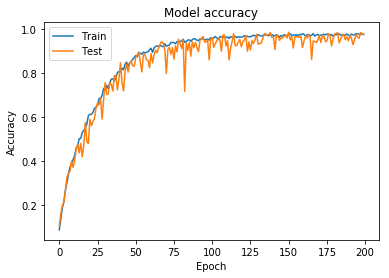

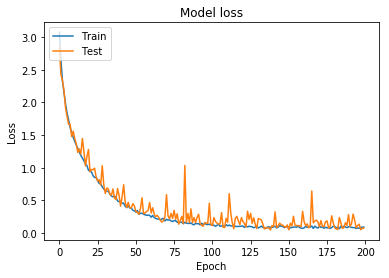

In [13]:
# Plot training & validation accuracy values (of first char only)
plt.plot(history.history['output_0_acc'])
plt.plot(history.history['val_output_0_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values (of first char only)
plt.plot(history.history['output_0_loss'])
plt.plot(history.history['val_output_0_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
nb_words_to_test = 100000

x_test = create_inputs(nb_words_to_test, nb_chars, nb_letters)

# normalize x_test data
x_test_normalized = normalize(x_test)

y_test_raw = encrypt(x_test, nb_words_to_test, nb_chars)
y_test_raw_cate = keras.utils.to_categorical(y_test_raw, nb_letters)

# process the y data as useful ANN multiple-outputs data
y_test = []
for c in range(nb_chars):
    # extract each 'char' colomn from the global y_train0 tensor
    # in order to have multiplue yi_train outputs tensors
    yi_test = np.ndarray(shape=(nb_words_to_test, 1, nb_letters))
    for w in range(nb_words):
        yi_test[w,:] = y_test_raw_cate[w,c,:]
    y_test.append(yi_test)

print('\n# Evaluate on test data')
results = coding_model.evaluate(x_test_normalized, y_test, batch_size=128)
for r in range(len(results)):
    print(coding_model.metrics_names[r],':',results[r])


# Evaluate on test data
100000/100000 [==============================] - 4s 40us/step
loss : 0.39301084247589113
output_0_loss : 0.03150831361413002
output_1_loss : 0.051943262299895286
output_2_loss : 0.10636471690177918
output_3_loss : 0.20319454999923706
output_0_acc : 0.41352
output_1_acc : 0.41009
output_2_acc : 0.39454
output_3_acc : 0.37301


In [15]:
nb_words_to_test = 3

x_test = create_inputs(nb_words_to_test, nb_chars, nb_letters)
print_readable_inputs(x_test)
print("x_test=\n", x_test)

x_test_scaled  = normalize(x_test)
print("x_test_scaled=\n", x_test_scaled)
print('-->')

prediction = coding_model.predict(x_test_scaled)
#print(prediction)
print('prediction')
print_readable_outputs(prediction, nb_words_to_test, nb_chars)

print('check prediction')
y_test = encrypt(x_test, nb_words_to_test, nb_chars)
print("y_test=\n", y_test)

[[array([121]), array([101]), array([104]), array([114])], [array([99]), array([102]), array([116]), array([111])], [array([117]), array([121]), array([116]), array([112])]]
x_test=
 [[[121]
  [101]
  [104]
  [114]]

 [[ 99]
  [102]
  [116]
  [111]]

 [[117]
  [121]
  [116]
  [112]]]
x_test_scaled=
 [[[ 0.90575292]
  [-0.76074973]
  [-1.41421356]
  [ 1.33630621]]

 [[-1.39346603]
  [-0.6520712 ]
  [ 0.70710678]
  [-1.06904497]]

 [[ 0.48771311]
  [ 1.41282093]
  [ 0.70710678]
  [-0.26726124]]]
-->
prediction
['19 7 2 23', '2 7 18 5', '16 23 18 10']
check prediction
y_test=
 [[[24]
  [ 4]
  [ 7]
  [17]]

 [[ 2]
  [ 5]
  [19]
  [14]]

 [[20]
  [24]
  [19]
  [15]]]
